The purpose of this to construct a simple low-dim setting that produces skewed posterior distribution so that we can evaluate the value of our algorithm. I am going to test the following inference:
   * NUTS: It is a sampling based approach that uses gradient of the model.
   * HamiltonianMC: similar to NUTs, the results are reasonable.
   * Metropolis: It is a sampling-based approach. The results are reasonable.
   * ADVI: This a kind of Varitional Bayes method. The results are pretty off!

In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats

import pymc3 as pm
import theano.tensor as tt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Some necessary function for plotting:

In [5]:
def plotTheResults(trace):
    # Obtain data from file.
    m1, m2 = trace['y_1'][::10], trace['y_2'][::10]
    xmin, xmax = -7.5, -5.75
    ymin, ymax = 4.8, 9

    # Perform a kernel density estimate (KDE) on the data
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Plot the results:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    # Set limits
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    # Draw contour lines
    cset = plt.contour(xx,yy,f)
    
    # plot the trace
    plt.figure()
    pm.plots.densityplot(trace, varnames=['y_1','y_2']);
    
    # more plot
    pm.traceplot(trace, varnames=['y_1','y_2']);
    
    # new plot
    plt.figure()
    dftrace = pm.trace_to_dataframe(trace)
    sb.jointplot(dftrace.iloc[::10, 0], dftrace.iloc[::10, 1], kind='kde');

# Read Data
We are going to replicate the results in this paper:

https://arxiv.org/pdf/1206.6679.pdf


In [6]:
data = pd.read_csv('cancermortality.csv')
x_data = np.array(data.y)
n_data = np.array(data.n)

In [7]:
data.head()

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208


# Model

The model is as follows:
$$
p(m,k) \propto \frac{1}{m(1-m)(1+K)^2} \\
P(x_j | m,K) = {n_j \choose x_j} \frac{B(Km+x_j , K(1-m) + n_j - x_j )}{ B(Km,K(1-m)) }
$$

The likelihood of this model is beta-binomial which looks like this:
$$
f(x \mid \alpha, \beta, n) =
       \binom{n}{x}
       \frac{B(x + \alpha, n - x + \beta)}{B(\alpha, \beta)}
$$
basically, in our likelihood $\alpha = Km$ and $\beta = K(1-m)$. Similar to the paper, we define two variables to avoid the constrins:

$$
y_1 = \text{logit}(m),\quad y_2 = \log(K) 
$$

# Metropolis

In [8]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    start = pm.find_MAP()
    trace = pm.sample(20000, step=pm.Metropolis(), 
                      njobs=1, chains=5, burn =5000, start=start)
    

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 393.58it/s]  
Sequential sampling (5 chains in 1 job)
Metropolis: [y]
100%|██████████| 20500/20500 [00:02<00:00, 7757.48it/s]
/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


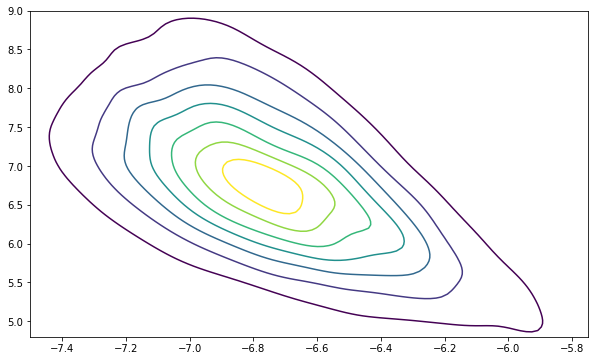

<Figure size 432x288 with 0 Axes>

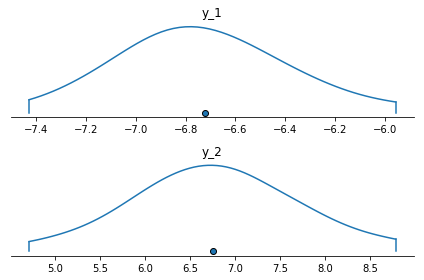

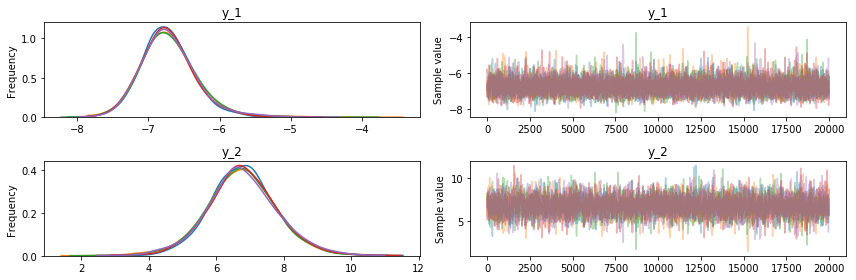

<Figure size 432x288 with 0 Axes>

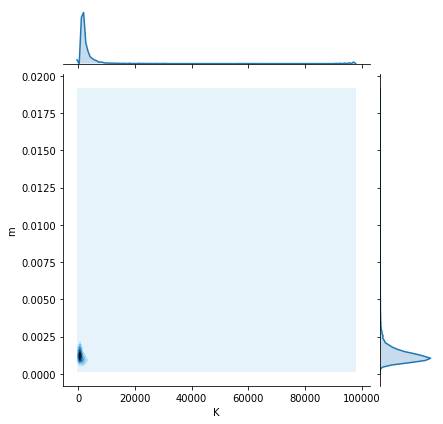

In [9]:
plotTheResults(trace)

# NUTs
Let's try different sampler:

In [16]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    
    trace = pm.sample(20000, step=pm.NUTS(), 
                      njobs=1, chains=5, burn =5000, start=start)



logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 2208.29it/s]  
Sequential sampling (5 chains in 1 job)
NUTS: [y]
100%|██████████| 20500/20500 [00:16<00:00, 1228.47it/s]
/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


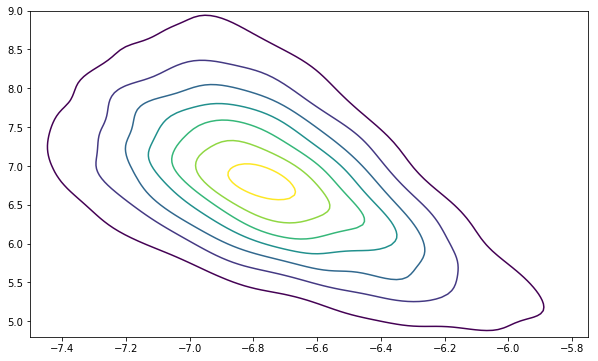

<Figure size 432x288 with 0 Axes>

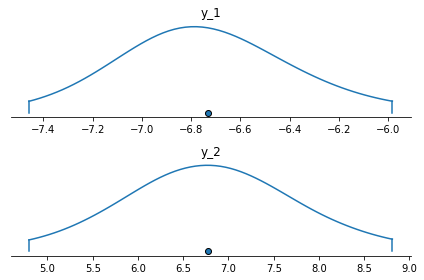

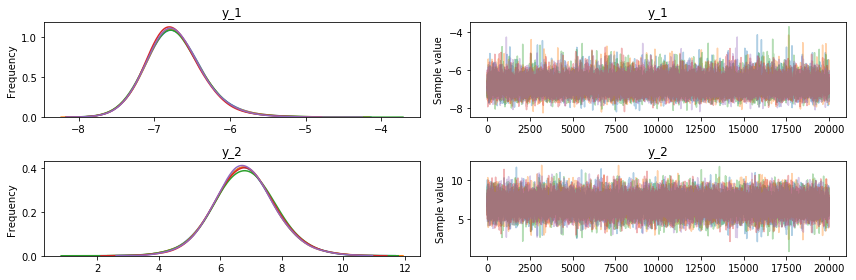

<Figure size 432x288 with 0 Axes>

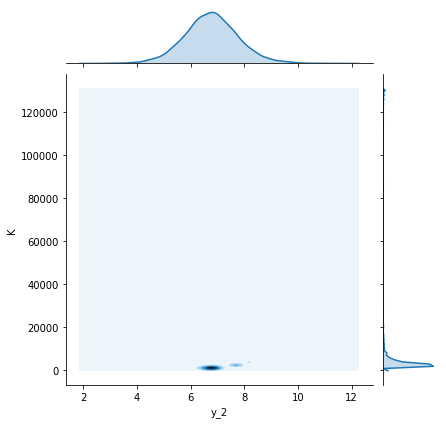

In [17]:
plotTheResults(trace)

/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


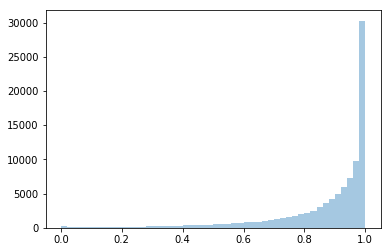

In [18]:
import seaborn as sb

accept = trace.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

# HamiltonianMC

In [19]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version
    
    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    
    trace = pm.sample(20000, step=pm.HamiltonianMC(), 
                      njobs=1, chains=5, burn =5000, start=start)



logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 1949.70it/s]  
Sequential sampling (5 chains in 1 job)
HamiltonianMC: [y]
100%|██████████| 20500/20500 [00:06<00:00, 2947.99it/s]
/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


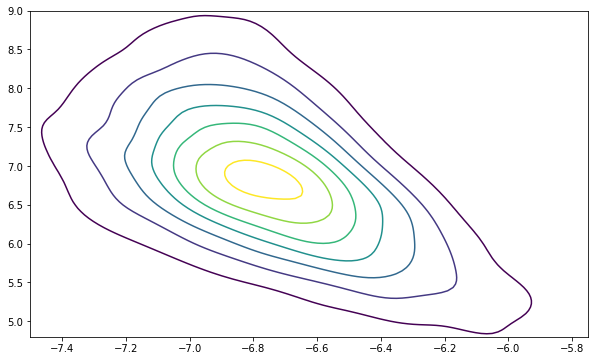

<Figure size 432x288 with 0 Axes>

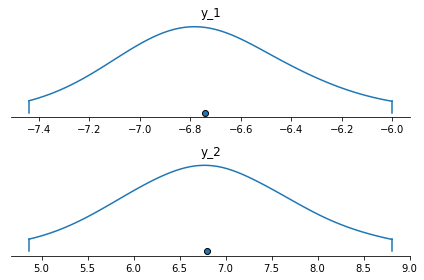

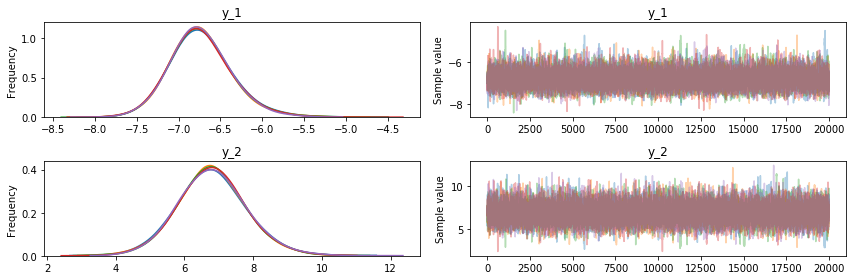

<Figure size 432x288 with 0 Axes>

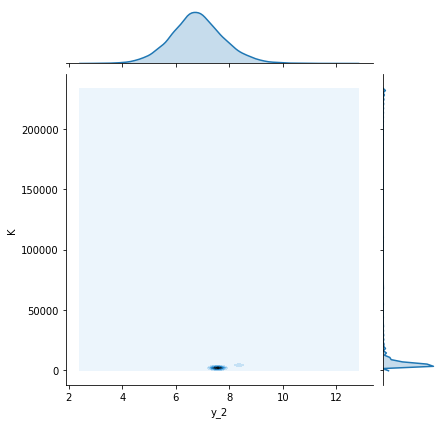

In [20]:
plotTheResults(trace)

# ADVI

In [21]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference, start=start)
    trace = approx.sample(draws=20000)
#     trace = pm.sample(20000, step=pm.HamiltonianMC(), 
#                       njobs=1, chains=5, burn =5000, start=start)



logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 1974.84it/s]  
Average Loss = 45.75: 100%|██████████| 30000/30000 [00:11<00:00, 2552.33it/s] 
Finished [100%]: Average Loss = 45.746


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


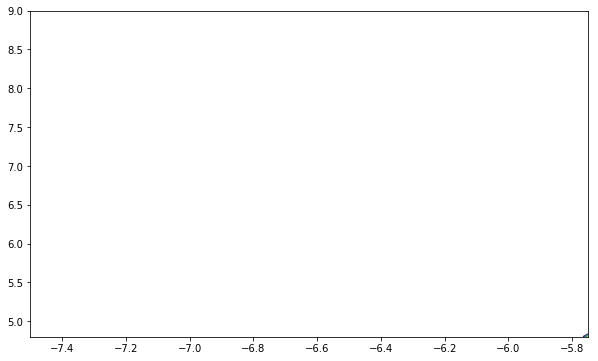

<Figure size 432x288 with 0 Axes>

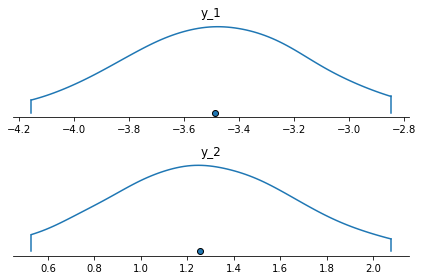

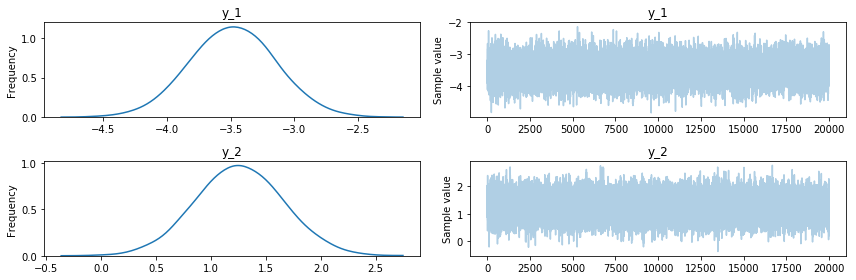

<Figure size 432x288 with 0 Axes>

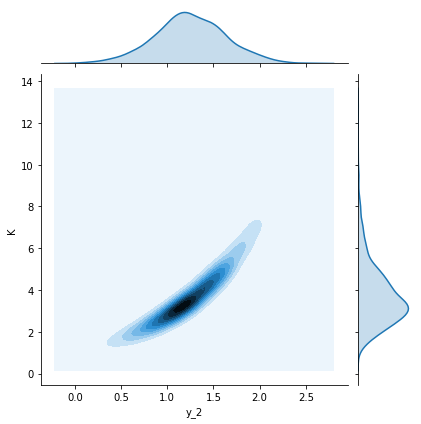

In [22]:
plotTheResults(trace)

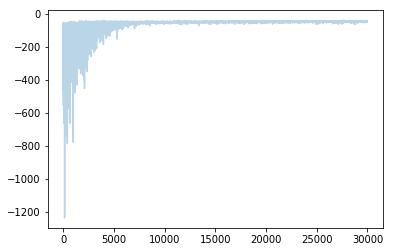

In [23]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)


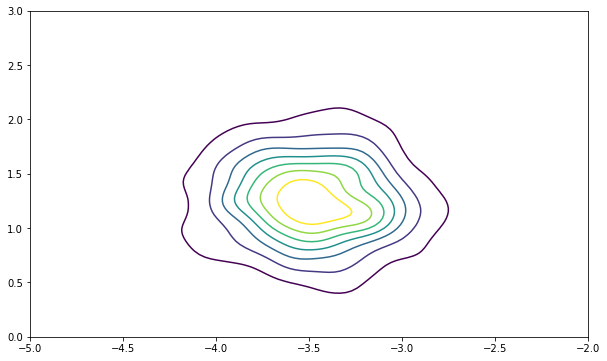

<Figure size 432x288 with 0 Axes>

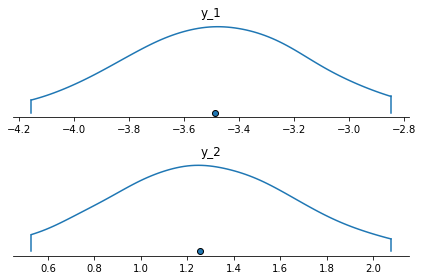

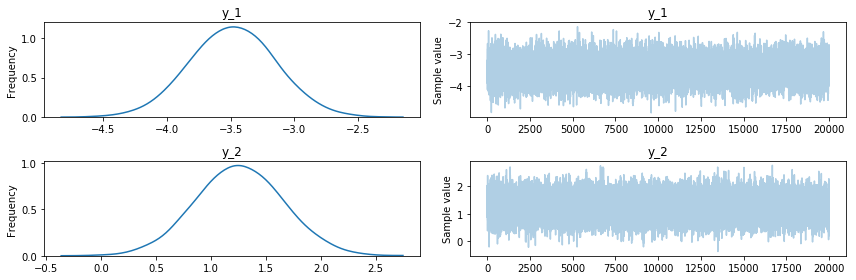

In [24]:
# Obtain data from file.
m1, m2 = trace['y_1'][::10], trace['y_2'][::10]
xmin, xmax = -5, -2
ymin, ymax = 0, 3

# Perform a kernel density estimate (KDE) on the data
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Set limits
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

# Draw contour lines
cset = plt.contour(xx,yy,f)

# plot the trace
plt.figure()
pm.plots.densityplot(trace, varnames=['y_1','y_2']);

# more plot
pm.traceplot(trace, varnames=['y_1','y_2']);

# Flow-based method

I am going to try different Flow-based approach. Overal results are reasonable:

  * One layer of plannar -- the results of this experimetn is off
  * 4 layers of plannar -- this is a bit off
  * scale followed by 4 layers of plannar and translation -- improved
  * scale followed by 10 layers of Hausehold and translation -- this is off
  * scale followed by 8 layers of plannar and translation -- This is the best results but it took a lot of params to get there!

In [25]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    inference = pm.NFVI('planar', jitter=1, start=start)
    #inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=20000)

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 2241.90it/s]  
Average Loss = 52.485: 100%|██████████| 30000/30000 [00:13<00:00, 2236.72it/s]
Finished [100%]: Average Loss = 52.461


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


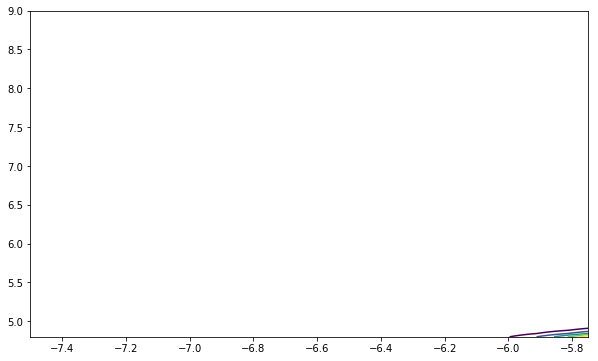

<Figure size 432x288 with 0 Axes>

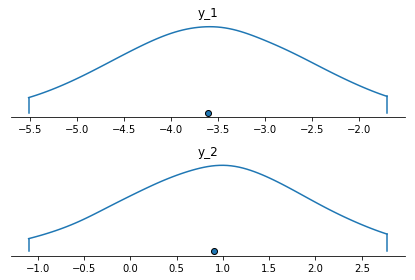

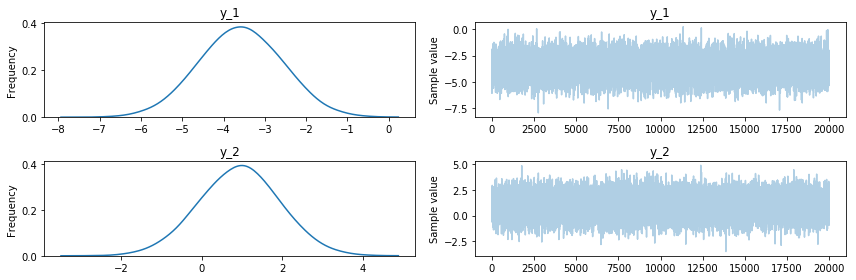

<Figure size 432x288 with 0 Axes>

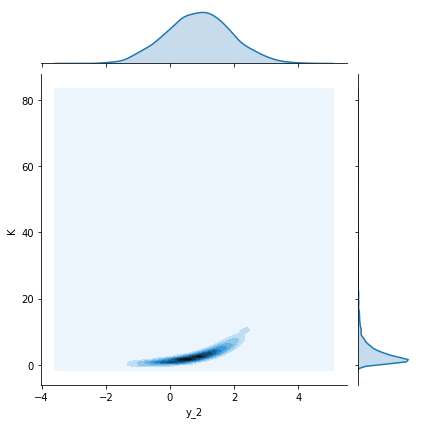

In [26]:
plotTheResults(trace)

In [27]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    inference = pm.NFVI('planar*4', jitter=1, start=start)
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=20000)

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 2540.26it/s]  
Average Loss = 36.655: 100%|██████████| 30000/30000 [00:25<00:00, 1161.71it/s]
Finished [100%]: Average Loss = 36.651


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


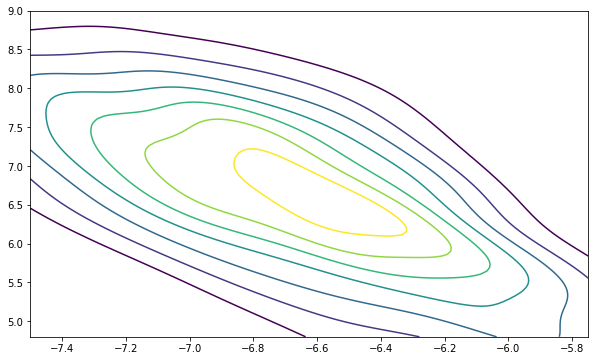

<Figure size 432x288 with 0 Axes>

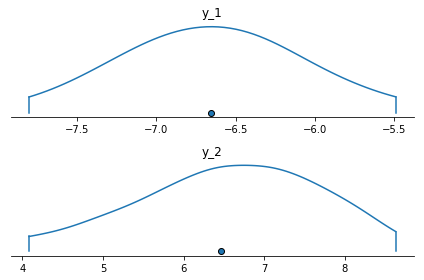

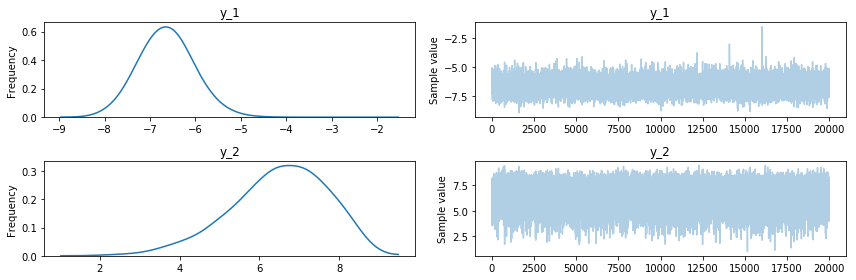

<Figure size 432x288 with 0 Axes>

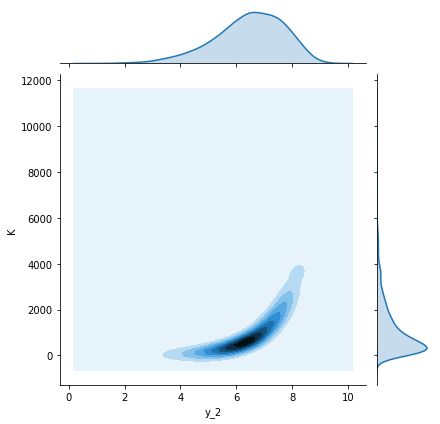

In [28]:
plotTheResults(trace)

In [49]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    inference = pm.NFVI('scale-planar*4-loc', jitter=1, start=start)
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=20000)

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 2408.59it/s]  
Average Loss = 36.327: 100%|██████████| 30000/30000 [00:28<00:00, 1036.24it/s]
Finished [100%]: Average Loss = 36.329


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


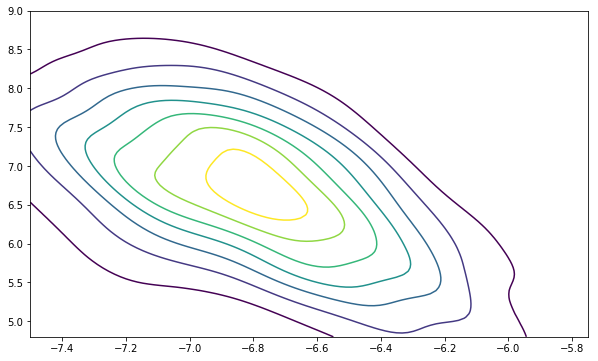

<Figure size 432x288 with 0 Axes>

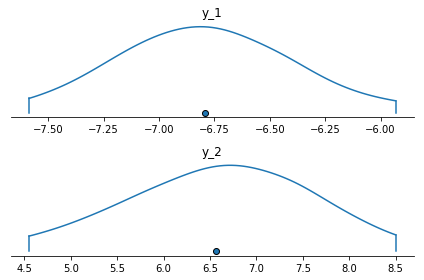

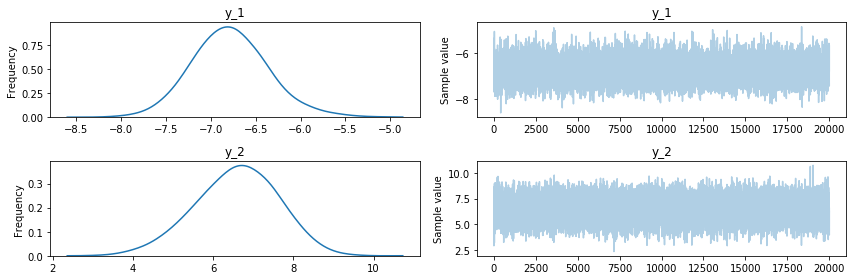

<Figure size 432x288 with 0 Axes>

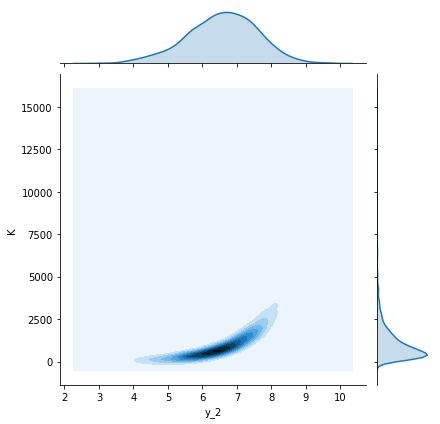

In [30]:
plotTheResults(trace)

In [31]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    inference = pm.NFVI('scale-hh*10-loc', jitter=1, start=start)
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=20000)

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 1904.73it/s]  
Average Loss = 42.122: 100%|██████████| 30000/30000 [00:22<00:00, 1360.57it/s]
Finished [100%]: Average Loss = 42.116


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


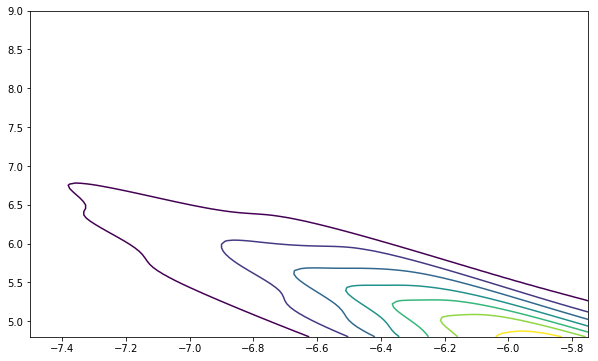

<Figure size 432x288 with 0 Axes>

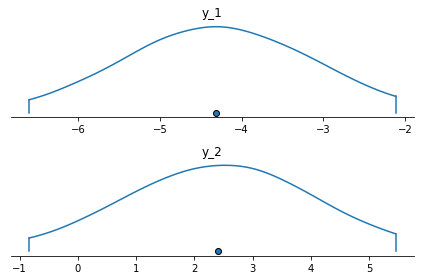

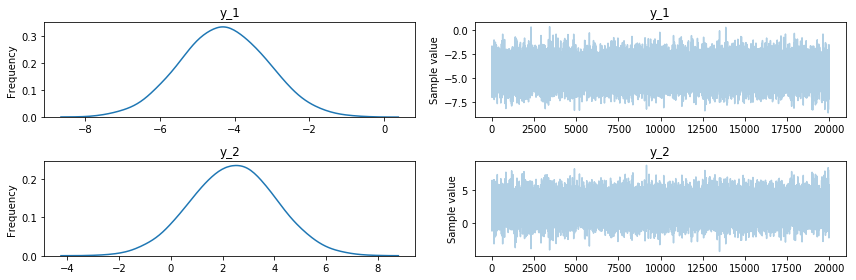

<Figure size 432x288 with 0 Axes>

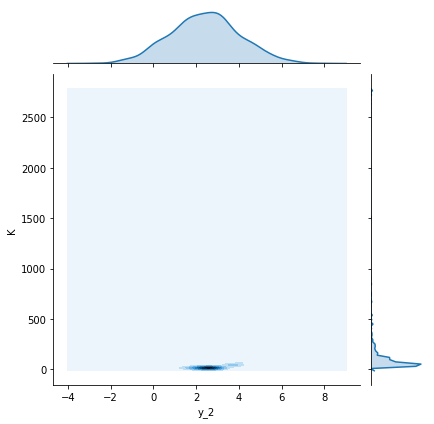

In [32]:
plotTheResults(trace)

In [20]:
with pm.Model() as model:
    def logp(value):
        y1 = value[0]
        y2 = value[1] 
        #m = 1 / (1 + np.exp(-y1))  # 1 / (1 + exp(-x))
        #K = np.exp(y2) # K = tt.exp(y2)
        #return -np.log(m) -np.log(1-m) - 2.0*np.log(1+K)  # original version
        #return np.log( 1 + np.exp(-y1) ) - ( -y1 - np.log( 1 + np.exp(-y1) ) ) - 2.0*np.log(1+ np.exp(y2)) # simplified version
        return  2.0*tt.log( 1 + tt.exp(-y1) ) +y1 - 2.0*tt.log(1+ tt.exp(y2)) # simplified version

    y = pm.DensityDist('y', logp, shape=2, testval = [0,1])
    m = pm.Deterministic('m', pm.invlogit(y[0]))
    K = pm.Deterministic('K', pm.math.exp(y[1]))
    y_1 = pm.Deterministic('y_1', y[0])
    y_2 = pm.Deterministic('y_2', y[1])
    
    X0 = pm.BetaBinomial('X', alpha=K*m, beta=K*(1-m), n=n_data, observed=x_data)
    
    start = pm.find_MAP()
    inference = pm.NFVI('scale-planar*8-loc', jitter=1, start=start)
    approx = pm.fit(n=30000, method=inference)
    trace = approx.sample(draws=20000)

logp = -36.75, ||grad|| = 8.278e-05: 100%|██████████| 23/23 [00:00<00:00, 2721.19it/s]  
Average Loss = 36.366: 100%|██████████| 30000/30000 [00:52<00:00, 570.05it/s]
Finished [100%]: Average Loss = 36.366


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


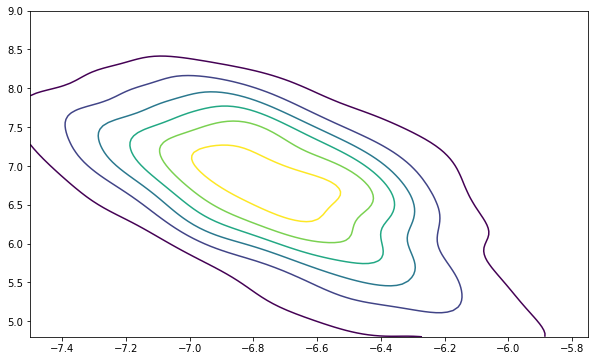

<Figure size 432x288 with 0 Axes>

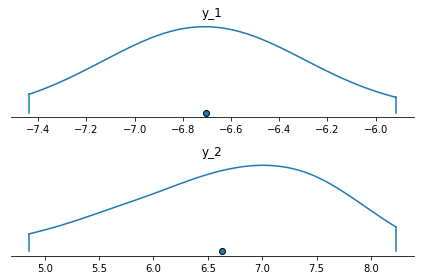

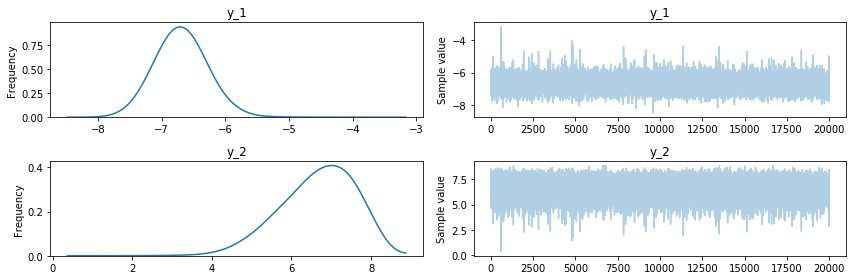

<Figure size 432x288 with 0 Axes>

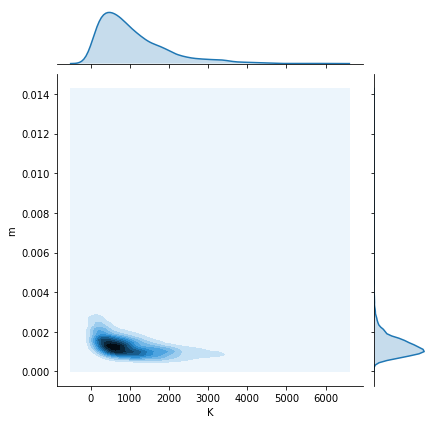

In [21]:
plotTheResults(trace)

# Planar Normalizing Flow (Our implementation)

I modified the `plotTheResults` funciton and commented out few plotting functions (see below) because I couldn't figure out yet how to create a `MultiTrace` instance yet.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
import pymc3 as pm

def plotTheResults_modified(trace):
    # Obtain data from file.
    m1, m2 = trace[::10,0], trace[::10,1]
    xmin, xmax = -7.5, -5.75
    ymin, ymax = 4.8, 9

    # Perform a kernel density estimate (KDE) on the data
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([m1, m2])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Plot the results:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    # Set limits
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    
    # Draw contour lines
    cset = plt.contour(xx,yy,f)
    
    # plot the trace
#     plt.figure()
#     pm.plots.densityplot(trace, varnames=['y_1','y_2']);
    
    # more plot
#     pm.traceplot(trace, varnames=['y_1','y_2']);
    
    
    # new plot
    plt.figure()
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    m=sigmoid(m1)
    K=np.exp(m2)
    dftrace = pd.DataFrame(data=np.stack([K,m]).T ,columns=['K','m'])
    sb.jointplot(dftrace.iloc[::10, 0], dftrace.iloc[::10, 1], kind='kde');


Populating the interactive namespace from numpy and matplotlib


/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Loss on iteration 300: 44.55345153808594
Loss on iteration 600: 39.49955749511719
Loss on iteration 900: 39.306087493896484
Loss on iteration 1200: 39.22089385986328
Loss on iteration 1500: 39.34770965576172
Loss on iteration 1800: 39.92812728881836
Loss on iteration 2100: 39.61396026611328
Loss on iteration 2400: 39.39227294921875
Loss on iteration 2700: 39.015907287597656
Loss on iteration 3000: 39.2845458984375
Loss on iteration 3300: 39.98493576049805
Loss on iteration 3600: 39.192283630371094
Loss on iteration 3900: 39.03528594970703
Loss on iteration 4200: 39.14684295654297
Loss on iteration 4500: 39.243587493896484
Loss on iteration 4800: 39.01089096069336
Loss on iteration 5100: 39.153663635253906
Loss on iteration 5400: 39.00453186035156
Loss on iteration 5700: 39.19658660888672
Loss on iteration 6000: 39.389564514160156
Loss on iteration 6300: 39.227020263671875
Loss on iteration 6600: 39.37941360473633
Loss on iteration 6900: 39.08140563964844
Loss on iteration 7200: 39.5950

/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


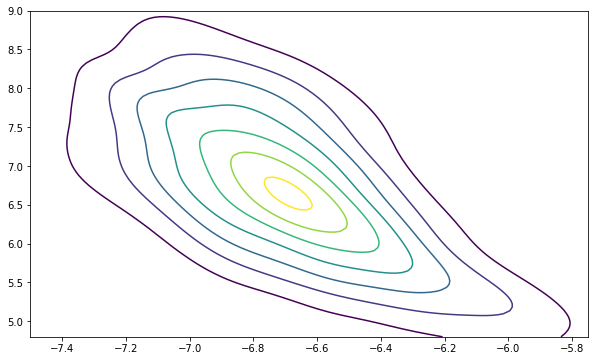

<Figure size 432x288 with 0 Axes>

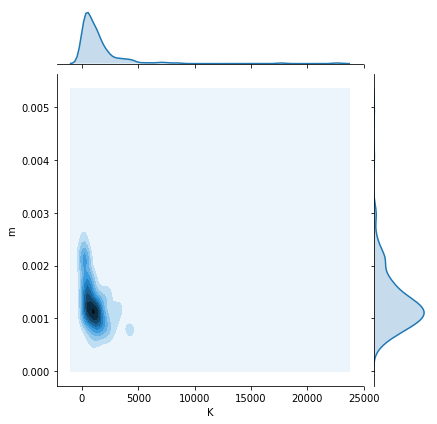

In [38]:
import sys
sys.path.append('/home/hadis/Hadi/nips_pgm/code')

%pylab inline

from distributions import density_1
from flows import ResnetFlow, PlanarFlow
from losses import elbo_loss, vanilla_vae_loss, elbo_loss_resnet, cross_entropy_loss, density_regeneration_loss
from mag.experiment import Experiment
from utils import plot_density, scatter_points, detJacHeatmap, deformationGrid, displacementField

import numpy as np
import tensorflow as tf
from IPython import embed

def logBetaBinomial(x,n,alpha,beta):
    def logComb(n,k):
        num = tf.lgamma(n+1)
        denum = tf.lgamma(k+1) + tf.lgamma(n-k+1)
        return tf.cast(num-denum, tf.float32)
    
    def betaln(x, y):
        return tf.cast(tf.lgamma(x) + tf.lgamma(y) - tf.lgamma(x + y), tf.float32)
        
#     val = bound(logComb(n,x) + betaln(x + alpha, n - x + beta) - betaln(alpha, beta),
#                     alpha > 0, beta > 0)
    val = logComb(n,x) + betaln(x + alpha, n - x + beta) - betaln(alpha, beta)
    return tf.cast(val,tf.float32)
   

def logModel(X,N,z):
    """
    X : array of x data
    N : array of N data
    z : it is vector of y_1 and y_2
    """
    y1, y2 = tf.split(z, [1,1], axis=1) 
    m = tf.sigmoid(y1)
    K = tf.exp(y2)
    logPrior = tf.cast(2.0*tf.log( 1 + tf.exp(-y1) ) +y1 - 2.0*tf.log(1+ tf.exp(y2)), tf.float32) 
    logp = 0
    for x,n in zip(X,N):
        logp = logp + logBetaBinomial(x, n , K*m, K*(1-m))
    
    logp = tf.reshape(logp,(-1,1)) + logPrior
    return logp

experiment = Experiment({ "batch_size": 40,
						"iterations": 10000,
						"learning_rate": 0.01,
						"flow_length": 4,
						"flow": "planar",
						"exp_name": "tempx"})

config = experiment.config
experiment.register_directory("distributions")
experiment.register_directory("postTrainingAnalysis")
experiment.register_directory("samples")
experiment.register_directory("tensorboard")

import pandas as pd

data = pd.read_csv('cancermortality.csv')
x_data = np.array(data.y, dtype=np.float)
n_data = np.array(data.n, dtype=np.float)

# Other parameters
z_dim = 2
log_interval = 300

density_2 = lambda z: tf.exp(logModel(x_data,n_data,z))

plot_density(density_2, directory=experiment.distributions, X_LIMS=(-8,-5),Y_LIMS=(4,8))

planar_flow_graph = tf.Graph()

with planar_flow_graph.as_default():
    Z = tf.placeholder(tf.float32, shape =[None, 2], name='random_sample')
    with tf.variable_scope('Flow'):
        if config.flow == 'resnet':
            flow = ResnetFlow(num_flows, num_cells_per_flow, z_dim, dt, approximation=approximation)
            z_k, sum_log_detj = flow.flow(Z)
        if config.flow == 'planar':
            flow = PlanarFlow(z_dim, num_flows=config.flow_length)
            z_k, sum_log_detj = flow.flow(Z)

    loss_op, density = density_regeneration_loss(density_2, z_k, sum_log_detj)
    tf.summary.scalar("loss", loss_op)

    global_step = tf.Variable(0, trainable=False, name='global_step')

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=config.learning_rate)
    gvs = optimizer.compute_gradients(loss_op)
    # capped_gvs = [(tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad), var) for grad, var in gvs]
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_op = optimizer.apply_gradients(capped_gvs)

    # train_op = tf.train.AdamOptimizer(config.learning_rate).minimize(loss_op, global_step=global_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(experiment.tensorboard)
    summaries = tf.summary.merge_all()

    for iteration in range(1, config.iterations + 1):
        z_samples = np.random.normal(0.0, 1.0, [config.batch_size,2])
        _, loss, _,sldg, summ, den, grads = sess.run([train_op, loss_op, z_k, sum_log_detj, summaries, density, capped_gvs], feed_dict={Z: z_samples})
        step = tf.train.global_step(sess, tf.train.get_global_step())
        # print('sum_log_detj',str(sldg))
        if iteration % log_interval == 0:
            writer.add_summary(summ, global_step=step)
            print("Loss on iteration {}: {}".format(iteration , loss))
            z_samples = np.random.normal(0.0, 1.0, [1000,z_dim])
            output = sess.run(z_k, feed_dict={Z: z_samples})
            scatter_points(
                output,
                directory=experiment.samples,
                iteration=iteration,
                flow_length=config.flow_length,
                X_LIMS=(-8,-5), 
                Y_LIMS=(4,8)
                )
    # Draw samples from the trained flow model and plot the resutls
    z_samples = np.random.normal(0.0, 1.0, [20000,z_dim])
    samples = sess.run(z_k, feed_dict={Z: z_samples})
    plotTheResults_modified(samples)

# Defeomorphic RNN Flow (Resnet - ours)

Loss on iteration 300: 57.71989059448242
Loss on iteration 600: 50.76511001586914
Loss on iteration 900: 49.625457763671875
Loss on iteration 1200: 46.81177520751953
Loss on iteration 1500: 45.76654815673828
Loss on iteration 1800: 44.487667083740234
Loss on iteration 2100: 43.565818786621094
Loss on iteration 2400: 41.94550704956055
Loss on iteration 2700: 40.98160934448242
Loss on iteration 3000: 39.997535705566406
Loss on iteration 3300: 39.626243591308594
Loss on iteration 3600: 39.27909469604492
Loss on iteration 3900: 39.16692352294922
Loss on iteration 4200: 39.64772415161133
Loss on iteration 4500: 39.491546630859375
Loss on iteration 4800: 39.98457717895508
Loss on iteration 5100: 39.29926681518555
Loss on iteration 5400: 38.89485549926758
Loss on iteration 5700: 38.85358810424805
Loss on iteration 6000: 39.728431701660156
Loss on iteration 6300: 39.47991943359375
Loss on iteration 6600: 39.125083923339844
Loss on iteration 6900: 39.281524658203125
Loss on iteration 7200: 39.3

/home/hadis/anaconda2/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


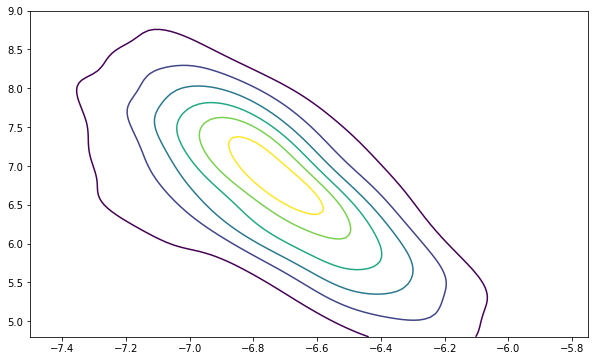

<Figure size 432x288 with 0 Axes>

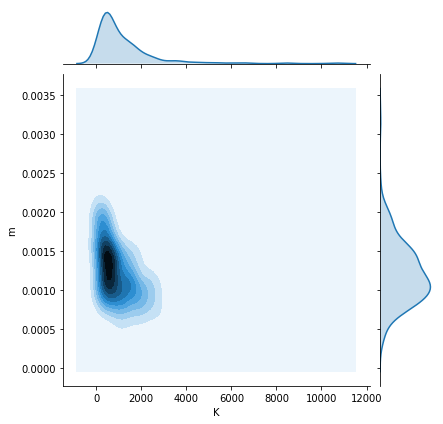

In [37]:
experiment = Experiment({ "batch_size": 40,
						"iterations": 10000,
						"learning_rate": 0.01,
						"flow_length": 4,
						"flow": "resnet",
						"exp_name": "tempx"})

config = experiment.config
experiment.register_directory("distributions")
experiment.register_directory("postTrainingAnalysis")
experiment.register_directory("samples")
experiment.register_directory("tensorboard")

import pandas as pd

data = pd.read_csv('cancermortality.csv')
x_data = np.array(data.y, dtype=np.float)
n_data = np.array(data.n, dtype=np.float)

# Other parameters
z_dim = 2
log_interval = 300

density_2 = lambda z: tf.exp(logModel(x_data,n_data,z))
plot_density(density_2, directory=experiment.distributions, X_LIMS=(-8,-5),Y_LIMS=(4,8))

resnet_flow_graph = tf.Graph()

with resnet_flow_graph.as_default():
    # ResnetFlow paramteres
    if config.flow == 'resnet':
        num_flows= config.flow_length
        num_cells_per_flow = 8
        dt = tf.constant(1.0/(num_cells_per_flow*num_flows), name='dt')
        approximation = 2 # 1 , 2 , 3 or 4 - None for exact calculation of the determinant of jacobian

    Z = tf.placeholder(tf.float32, shape =[None, 2], name='random_sample')

    with tf.variable_scope('Flow'):
        if config.flow == 'resnet':
            flow = ResnetFlow(num_flows, num_cells_per_flow, z_dim, dt, approximation=approximation)
            z_k, sum_log_detj = flow.flow(Z)
        if config.flow == 'planar':
            flow = PlanarFlow(z_dim, num_flows=config.flow_length)
            z_k, sum_log_detj = flow.flow(Z)

    loss_op, density = density_regeneration_loss(density_2, z_k, sum_log_detj)
    tf.summary.scalar("loss", loss_op)

    global_step = tf.Variable(0, trainable=False, name='global_step')

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=config.learning_rate)
    gvs = optimizer.compute_gradients(loss_op)
    # capped_gvs = [(tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad), var) for grad, var in gvs]
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    train_op = optimizer.apply_gradients(capped_gvs)

    # train_op = tf.train.AdamOptimizer(config.learning_rate).minimize(loss_op, global_step=global_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(experiment.tensorboard)
    summaries = tf.summary.merge_all()

    for iteration in range(1, config.iterations + 1):
        z_samples = np.random.normal(0.0, 1.0, [config.batch_size,2])
        _, loss, _,sldg, summ, den, grads = sess.run([train_op, loss_op, z_k, sum_log_detj, summaries, density, capped_gvs], feed_dict={Z: z_samples})
        step = tf.train.global_step(sess, tf.train.get_global_step())
        # print('sum_log_detj',str(sldg))
        if iteration % log_interval == 0:
            writer.add_summary(summ, global_step=step)
            print("Loss on iteration {}: {}".format(iteration , loss))
            z_samples = np.random.normal(0.0, 1.0, [1000,z_dim])
            output = sess.run(z_k, feed_dict={Z: z_samples})
            scatter_points(
                output,
                directory=experiment.samples,
                iteration=iteration,
                flow_length=config.flow_length,
                X_LIMS=(-8,-5), 
                Y_LIMS=(4,8)
                )
    
    # Draw samples from the trained flow model and plot the resutls
    z_samples = np.random.normal(0.0, 1.0, [20000,z_dim])
    samples = sess.run(z_k, feed_dict={Z: z_samples})
    plotTheResults_modified(samples)